# Compute rotary spectra from mitgcm outputs


---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft
import cartopy.crs as ccrs
from cmocean import cm

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(20)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

<Client: scheduler='tcp://10.148.1.2:34652' processes=40 cores=160>

____
# Compute and store spectra for blocks

In [6]:
v = 'SSU'

## open files, nc files
ncdata_dir = '/home1/scratch/xyu/mit_nc_new/'

# dir where spectra are stored
E_dir = '/home1/scratch/xyu/mit_spec/E_uv_test_new/'

print(ncdata_dir)
print(E_dir)


# number of fies to load for each face (1 file = 10 days)
Nf = 1

mgrid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])



/home1/scratch/xyu/mit_nc_new/
/home1/scratch/xyu/mit_spec/E_uv_test_new/


In [7]:
face = 5

filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
filenames = filenames[:Nf]

grid = mgrid.isel(face=face)
    
ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

chunks={'time': len(ds['time'])}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320, time: 1440)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 5
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    dtime    (time) datetime64[ns] dask.array<shape=(1440,), chunksize=(1440,)>
Data variables:
    SSU      (i, j, time) float32 dask.array<shape=(4320, 4320, 1440), chunksize=(10, 432, 1440)>


In [8]:
u = ds[v].persist()

In [10]:
v_fft = xrft.dft(u.fillna(0.), dim=['time'], shift=False, detrend='linear',window=True)
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i','j'))/u.time.size*3600
E = E.astype('f8').rename('E')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [11]:
%time E.load()

KilledWorker: ("('isna-where-detrend-b6c979db4ea2fc77904d923ef350eb6d', 24, 2, 0)", 'tcp://10.148.1.32:40523')

AttributeError: 'Dataset' object has no attribute 'plot'

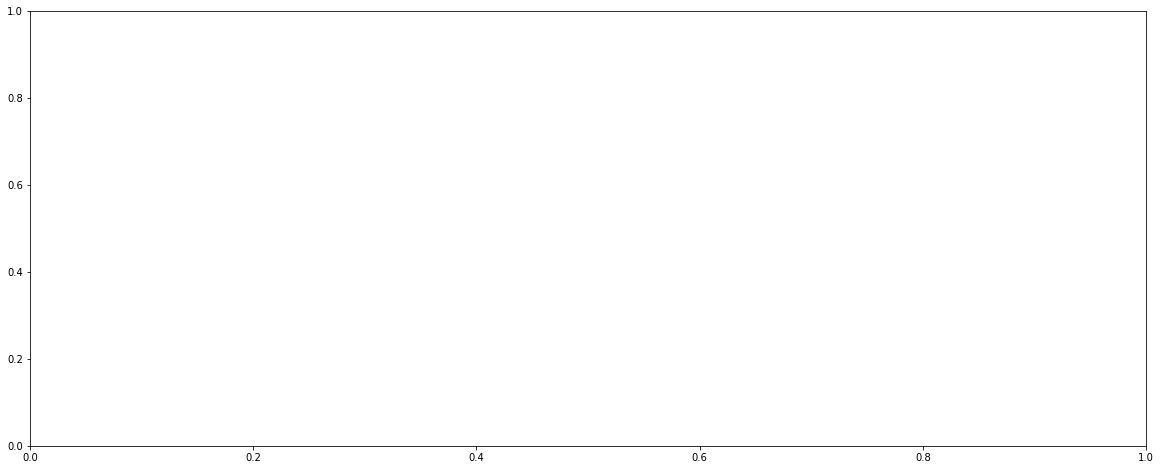

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
E.where(E.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-5,3*1e-5])
ax.set_ylim([1e-1,1e6])

# M2 #
ax.plot([1/12.42/3600,1/12.42/3600],[1e-2,1e6],'k--') 
ax.plot([1/12/3600,1/12/3600],[1e-2,1e6],'r--') 
ax.plot([1/12.58/3600,1/12.58/3600],[1e-2,1e6],'b--') 

# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--')
ax.plot([1/25.81/3600,1/25.81/3600],[1e-2,1e6],'k--')




In [12]:
for face in range(5,6):

    filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
    filenames = filenames[:Nf]

    grid = mgrid.isel(face=face)
    
    ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    #ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')

    
    chunks={'time': len(ds['time'])}
    ds = ds.chunk(chunks)

    
    nfft = 480
    noverlap = nfft/2
    window = np.hanning(nfft)

    SSU = ds[v]
    T = np.arange(0, len(SSU.time)-int(nfft/2), int(nfft/2))
    print(T)

    for t in T:
    
        u = ds[v].isel(time=slice(t,t+nfft))#############


        v_fft = xrft.dft(window*u.fillna(0.), dim=['time'], shift=False, detrend='linear')
        E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False)
        E = E.astype('f8').rename('E')
        E = xr.merge([E, grid])

        file_E = E_dir+'E_SSU_t%04d.nc'%t    
        E.to_netcdf(file_E, mode='w')
    
    #print('face %d done'%face )

[  0 240 480 720 960]


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 2.52 MB detected in task graph: 
  ("('astype-28438f2ef6d54649b427428a92b5db27', 0, 0 ... 9b35>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_futu

# Read block-resolved spectral data

In [7]:
filenames = sorted(glob(E_dir+'E_SSU_t*.nc'))
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='blocks', compat='equals')
print(ds)

CPU times: user 1min 3s, sys: 4.11 s, total: 1min 7s
Wall time: 2min 44s
<xarray.Dataset>
Dimensions:            (blocks: 6, freq_time: 240, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.157e-06 2.315e-06 3.472e-06 ...
    freq_time_spacing  float64 1.157e-06
    face               int64 5
    XC                 (i, j) float32 52.010418 52.010418 52.010418 ...
    YC                 (i, j) float32 13.746807 13.765447 13.784085 ...
    rA                 (i, j) float32 4662595.0 4661817.5 4661038.5 ...
    Depth              (i, j) float32 2322.3052 2333.45 2371.964 2333.45 ...
Dimensions without coordinates: blocks
Data variables:
    E                  (blocks, i, j, freq_time) float64 dask.array<shape=(6, 4320, 4320, 240), chunksize=(1, 10, 432, 240)>


In [9]:
ds = ds.assign_coords(freq_cpd=ds.freq_time * 86400.)
print(ds)

<xarray.Dataset>
Dimensions:            (blocks: 6, freq_time: 240, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.157e-06 2.315e-06 3.472e-06 ...
    freq_time_spacing  float64 1.157e-06
    face               int64 5
    XC                 (i, j) float32 52.010418 52.010418 52.010418 ...
    YC                 (i, j) float32 13.746807 13.765447 13.784085 ...
    rA                 (i, j) float32 4662595.0 4661817.5 4661038.5 ...
    Depth              (i, j) float32 2322.3052 2333.45 2371.964 2333.45 ...
    freq_cpd           (freq_time) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 ...
Dimensions without coordinates: blocks
Data variables:
    E                  (blocks, i, j, freq_time) float64 dask.array<shape=(6, 4320, 4320, 240), chunksize=(1, 10, 432, 240)>


# Band integration

In [9]:
print(ds.freq_cpd[0:120]) # 1 cpd

<xarray.DataArray 'freq_cpd' (freq_time: 120)>
array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,
        2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,
        3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,
        4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,
        6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,
        7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,
        8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,
        9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7,
       10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.157e-06 2.315e-06 3.472e-06 ...
    freq_time_spacing  float64 1.157e-06
    face               int6

In [10]:
print(ds.freq_cpd[0:20]) # 1 cpd

<xarray.DataArray 'freq_cpd' (freq_time: 20)>
array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.157e-06 2.315e-06 3.472e-06 ...
    freq_time_spacing  float64 1.157e-06
    face               int64 5
    freq_cpd           (freq_time) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 ...


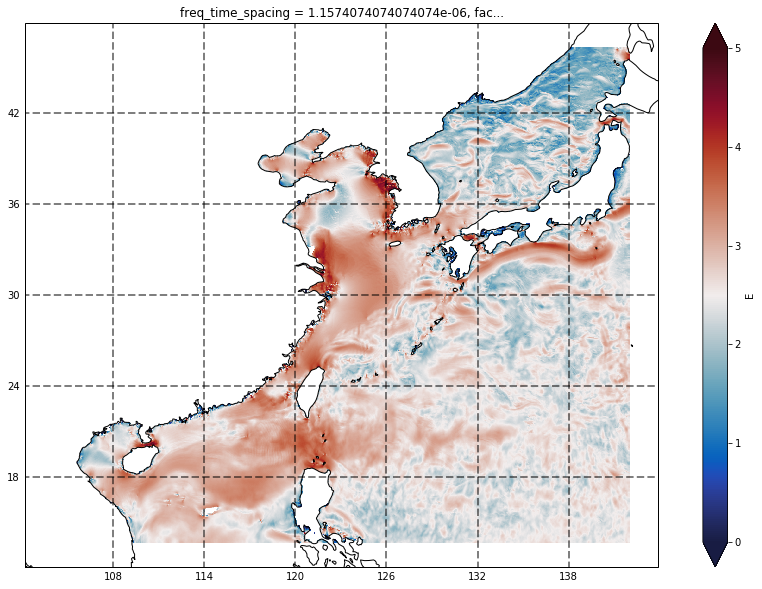

In [15]:
eta = ds['E'].isel(blocks=4, i=slice(2500,4320), j=slice(0,2000), freq_time=slice(0,120)).sum(dim='freq_time') 
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 5, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

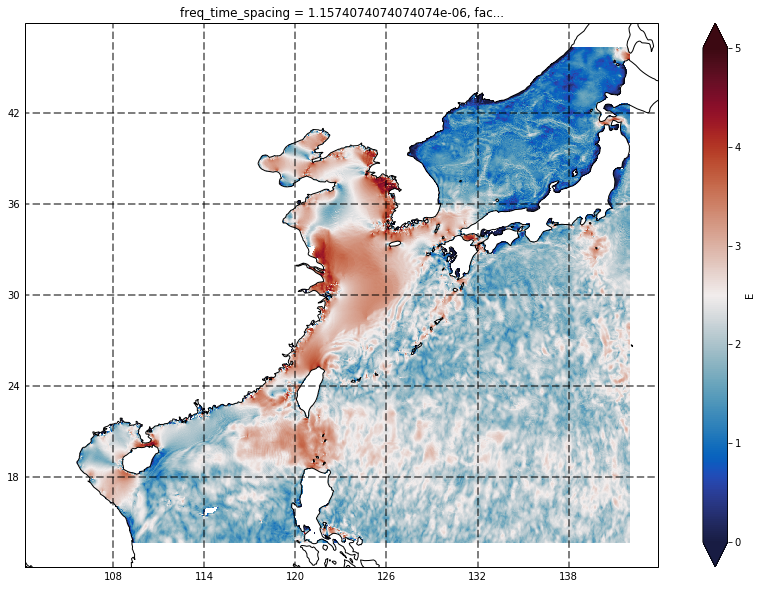

In [16]:
eta = ds['E'].isel(blocks=4, i=slice(2500,4320), j=slice(0,2000), freq_time=slice(10,120)).sum(dim='freq_time') 
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 5, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

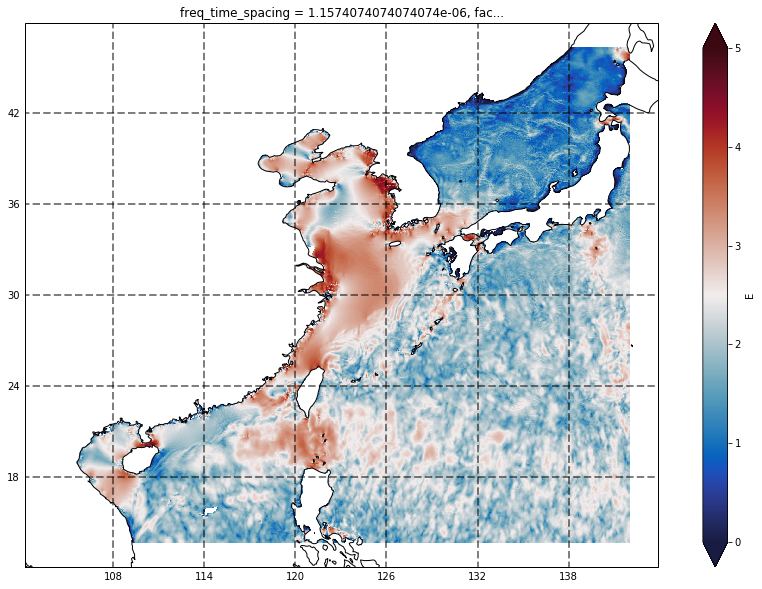

In [17]:
eta = ds['E'].isel(blocks=4, i=slice(2500,4320), j=slice(0,2000), freq_time=slice(9,22)).sum(dim='freq_time') 
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 5, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

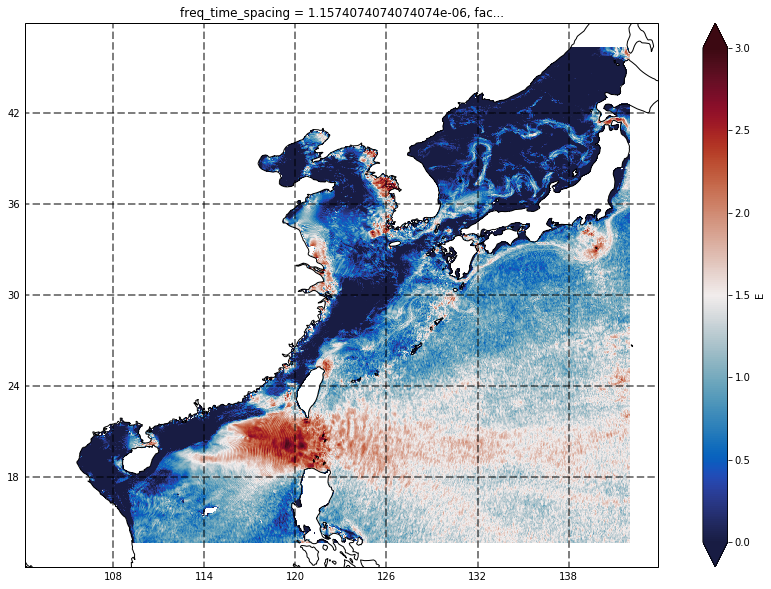

In [20]:
eta = ds['E'].isel(blocks=4, i=slice(2500,4320), j=slice(0,2000), freq_time=slice(25,120)).sum(dim='freq_time') 
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 3, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

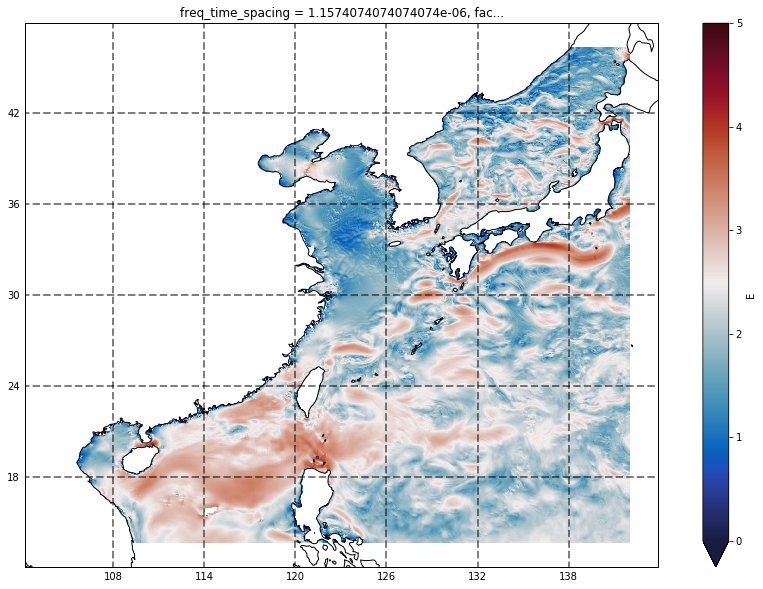

In [14]:
eta = ds['E'].isel(blocks=4, i=slice(2500,4320), j=slice(0,2000), freq_time=slice(0,10)).sum(dim='freq_time') 

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 5, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

# k1

In [20]:
print(ds.freq_cpd[0:10]) # 1 cpd

<xarray.DataArray 'freq_cpd' (freq_time: 10)>
array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.157e-06 2.315e-06 3.472e-06 ...
    freq_time_spacing  float64 1.157e-06
    face               int64 5
    freq_cpd           (freq_time) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 ...


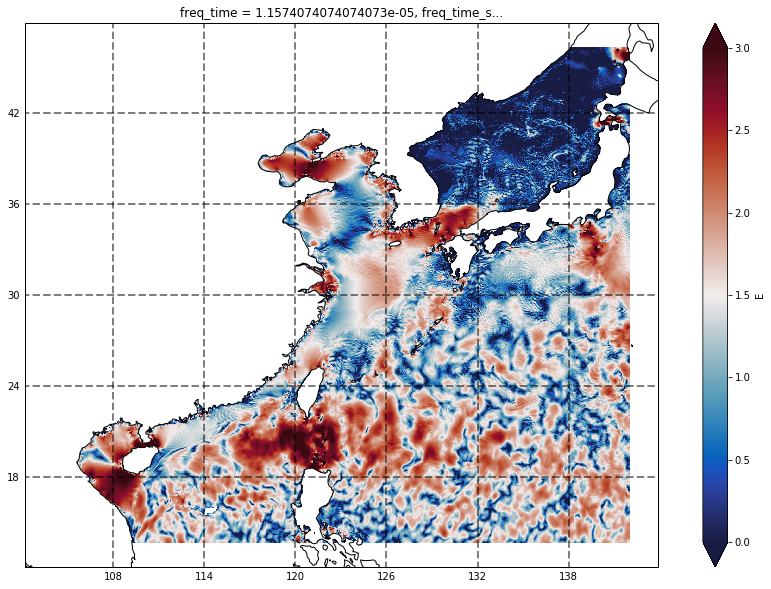

In [10]:
# one specific frequency (1 psd) on a block

import cartopy.crs as ccrs
from cmocean import cm

eta = ds['E'].isel(blocks=4, freq_time=10, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 3, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

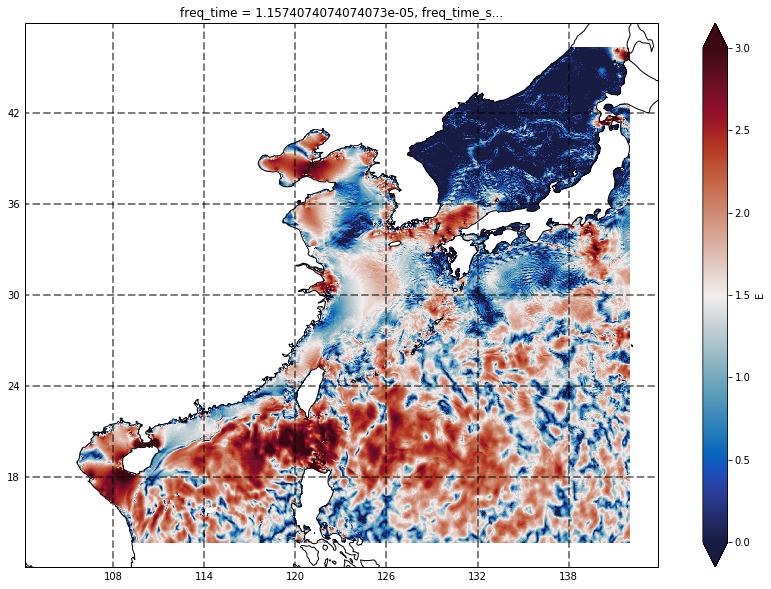

In [47]:
# one specific frequency on a block

import cartopy.crs as ccrs
from cmocean import cm

eta = ds['E'].isel(blocks=2, freq_time=10, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 3, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

# M2

In [48]:
print(ds.freq_cpd[20]) # 2 cpd --> M2

<xarray.DataArray 'freq_cpd' ()>
array(2.)
Coordinates:
    freq_time          float64 2.315e-05
    freq_time_spacing  float64 1.157e-06
    face               int64 5
    freq_cpd           float64 2.0


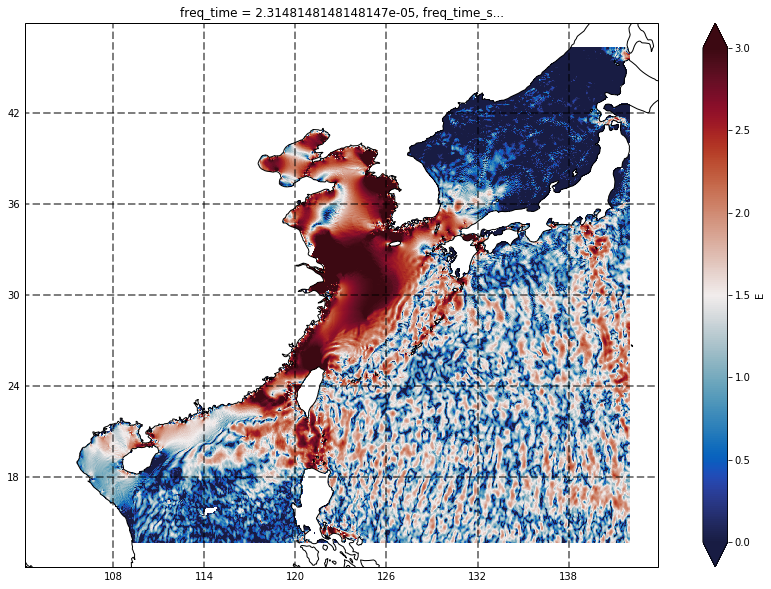

In [49]:
# one specific frequency on a block

import cartopy.crs as ccrs
from cmocean import cm

eta = ds['E'].isel(blocks=4, freq_time=20, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 3, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

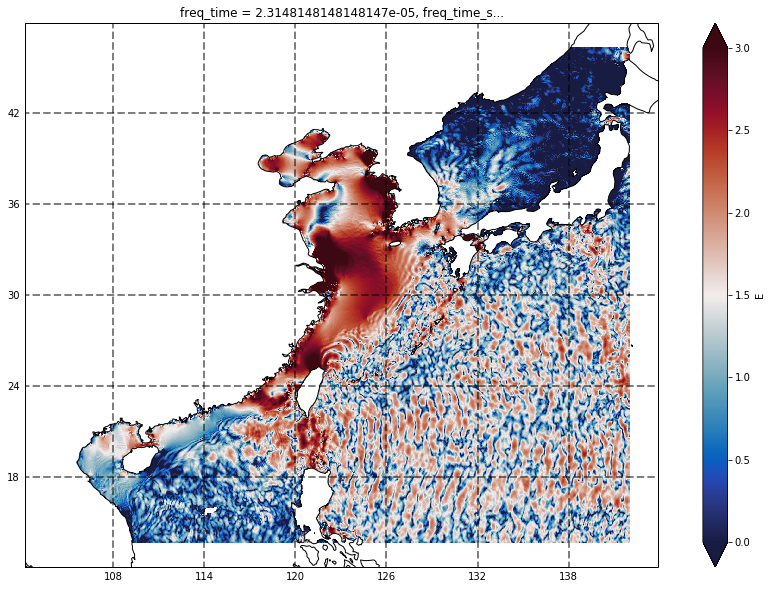

In [50]:
# one specific frequency on a block

import cartopy.crs as ccrs
from cmocean import cm

eta = ds['E'].isel(blocks=2, freq_time=20, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 3, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

# M4

In [51]:
print(ds.freq_cpd[40]) # 4 cpd --> M4

<xarray.DataArray 'freq_cpd' ()>
array(4.)
Coordinates:
    freq_time          float64 4.63e-05
    freq_time_spacing  float64 1.157e-06
    face               int64 5
    freq_cpd           float64 4.0


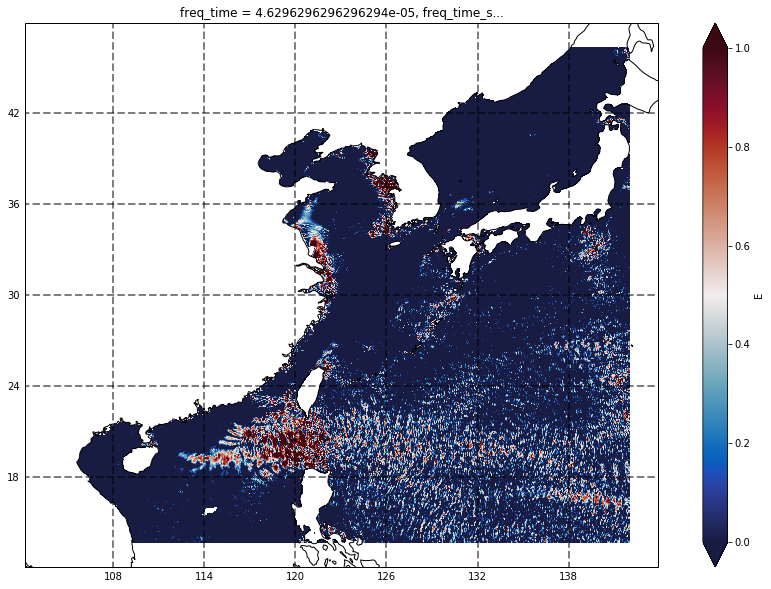

In [53]:
# one specific frequency on a block

import cartopy.crs as ccrs
from cmocean import cm

eta = ds['E'].isel(blocks=4, freq_time=40, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 1, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

# Low-freq

In [55]:
print(ds.freq_cpd[2]) # 0.2 cpd ~~ 5 days

<xarray.DataArray 'freq_cpd' ()>
array(0.2)
Coordinates:
    freq_time          float64 2.315e-06
    freq_time_spacing  float64 1.157e-06
    face               int64 5
    freq_cpd           float64 0.2


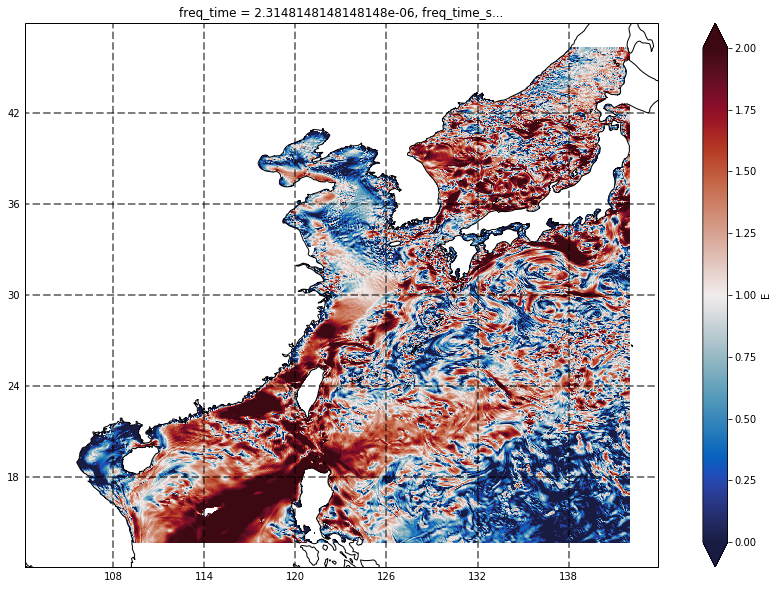

In [56]:
# one specific frequency on a block

import cartopy.crs as ccrs
from cmocean import cm

eta = ds['E'].isel(blocks=4, freq_time=2, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 2, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

# Average over the whole domain


It seems no obvious improvement after applying windowing and 50% overlapping...

No handles with labels found to put in legend.


CPU times: user 736 ms, sys: 4 ms, total: 740 ms
Wall time: 11.5 s
CPU times: user 4.36 s, sys: 56 ms, total: 4.41 s
Wall time: 50.2 s


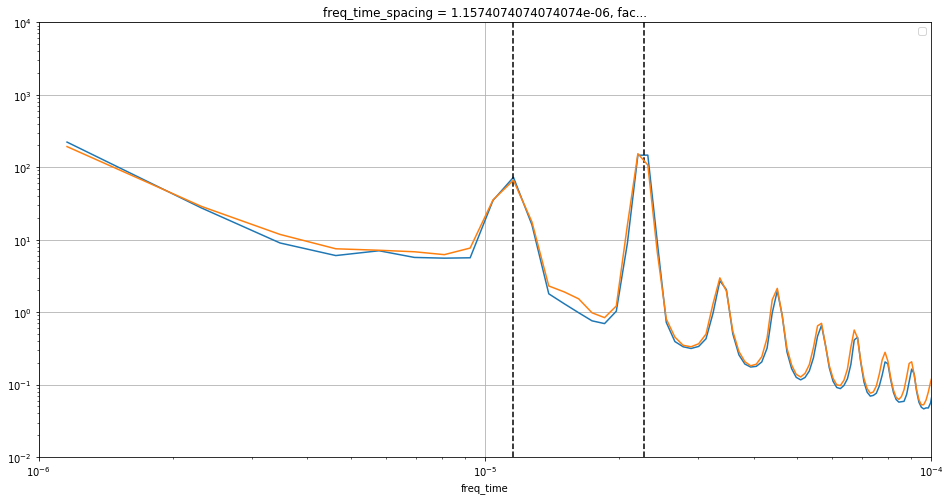

In [34]:
E = ds.E

fig, ax = plt.subplots(figsize=(16,8))
%time E.isel(blocks=4, i=slice(2500,4320), j=slice(0,2000)).where(E.freq_time>0).mean(dim=['i','j']).plot() # average over the domain
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
ax.set_xlim([1e-6,1e-4])
ax.set_ylim([1e-2,1e4])

ax.plot([1/12.24/3600,1/12.24/3600],[1e-2,1e6],'k--') 
ax.plot([1/24/3600,1/24/3600],[1e-2,1e6],'k--') 

# average over blocks
%time E.isel(i=slice(2500,4320), j=slice(0,2000)).where(E.freq_time>0).mean(dim=['i','j', 'blocks']).plot() # average over the domain and blocks

# Block-averaging and zonally averaging

In [ ]:
E = (ds.E).mean(dim='blocks')
print(E)

In [ ]:
face = 5

file_E = E_dir+'E_u_f%02d.nc'%face   
E.to_netcdf(file_E, mode='w') 

In [ ]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
for face in range(5,6):

    file_E = E_dir+'E_u_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})
    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')
    ds_zavg.to_netcdf(E_dir+'E_SSU_zavg_f%02d.nc'%face, mode='w')

## load and plot zonally averaged spectra

In [13]:
filenames = sorted(glob(E_dir+'E_SSU_zavg_f*.nc'))
%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')


CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 90.8 ms


In [14]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
print(E)

<xarray.DataArray (lat: 120, freq_time: 239)>
dask.array<shape=(120, 239), dtype=float64, chunksize=(120, 239)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001383 -0.0001372 -0.000136 ...


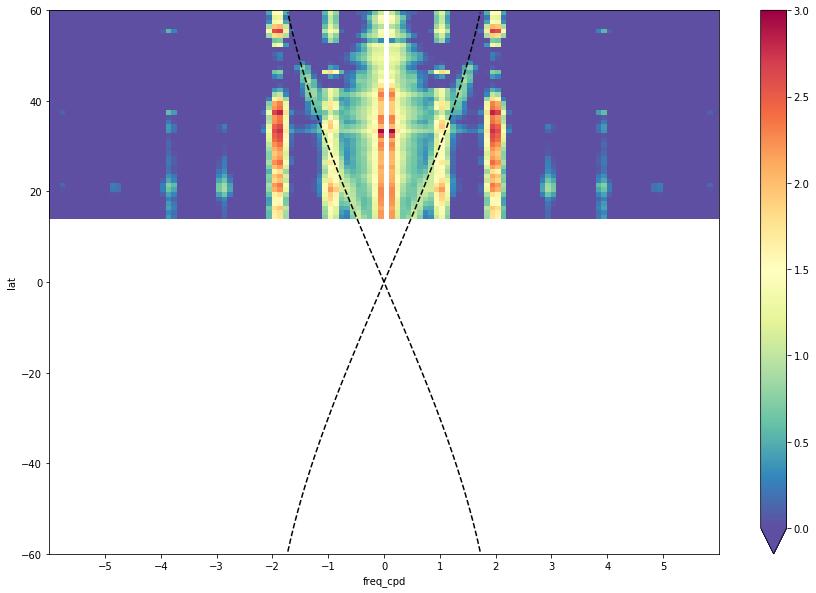

In [15]:
import cmocean

plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.)
np.log10(E).plot.pcolormesh(ax=ax, vmin=-0., vmax=3., x='freq_cpd', y='lat', cmap = 'Spectral_r')

ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-12., 12.)
ax.set_xlim(-6., 6.)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

---

In [13]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['OK', 'OK', 'OK', 'OK', 'timed out', 'timed out', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'timed out', 'timed out', 'OK', 'OK', 'timed out', 'timed out', 'OK', 'OK', 'timed out', 'timed out', 'OK', 'OK', 'timed out', 'timed out', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK', 'OK']
NoneType: None


<Client: scheduler='tcp://10.148.1.2:34652' processes=38 cores=152>